# Word Sense Disambiguation (снятие лексической неоднозначности слов) и Word Sense Induction (нахождение значений слова)

WSD и WSI  - это связанные задачи про определение значений, в которых употребляются слова. WSI занимается определением возможных значений слова, а WSD нужна для того, чтобы определить, в каком из имеющихся значений слово употреблено в тексте. 

Основное предположение, на котором строятся все модели для снятия и определения неоднозначности - значение определяется в контексте (отличие от эмбедингов в том, что тут имеется в виду конкретный контекст и конкретное значение, а не набор всех контекстов и общее значение=смысл слова). 

На практике WSD/WSI применяются достаточно редко. Современные модели (вроде BERT) используют фиксированные эмбединги для отдельных слов и преобразуют их в зависимости от контекста. Преобразованные (контекстуализированные) эмбединги удобно использовать для предсказания (именованных сущностей, частей речи, перевода), но из них нельзя вытащить информацию о том, сколько значений есть у слова. А это может требоваться в специфичных лингвистических задачах.   

Готовых инстурментов тоже не очень много и они малоизвестные. В семинаре мы попробуем одну библиотеку - adagram.

In [5]:
!pip install Cython numpy
!pip install git+https://github.com/lopuhin/python-adagram.git

You should consider upgrading via the '/Users/mnefedov/.pyenv/versions/3.7.2/bin/python3.7 -m pip install --upgrade pip' command.
  Cloning https://github.com/lopuhin/python-adagram.git to /private/var/folders/sw/k25rhtrn2psc2hztd0t4tqmh0000gn/T/pip-req-build-eg0pqctv
  Running command git clone -q https://github.com/lopuhin/python-adagram.git /private/var/folders/sw/k25rhtrn2psc2hztd0t4tqmh0000gn/T/pip-req-build-eg0pqctv
  Created wheel for adagram: filename=adagram-0.0.1-cp37-cp37m-macosx_11_0_x86_64.whl size=220772 sha256=a6542ad6fc1d4e2cd04111ee3b13451732f899d51fa38f60cececdf0ed3eaad8
  Stored in directory: /private/var/folders/sw/k25rhtrn2psc2hztd0t4tqmh0000gn/T/pip-ephem-wheel-cache-z4lmd6fh/wheels/5a/8c/f9/7dee902dd325a3317e768f126aa6f7aa085c79a6e763ed2cb8
Successfully built adagram
You should consider upgrading via the '/Users/mnefedov/.pyenv/versions/3.7.2/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
!pip install lxml

     |████████████████████████████████| 4.5 MB 2.8 MB/s eta 0:00:01
You should consider upgrading via the '/Users/mnefedov/.pyenv/versions/3.7.2/bin/python3.7 -m pip install --upgrade pip' command.


In [56]:
import adagram
from lxml import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from pymorphy2 import MorphAnalyzer
from string import punctuation
import json, os, re, sys
from collections import Counter
import numpy as np
from razdel import tokenize as razdel_tokenize
from matplotlib import pyplot as plt
import gensim
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import tqdm
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [token.text.strip(punct) for token in list(razdel_tokenize(text))]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return words


## Адаграм

Word2Vec и Fasttext каждому слову (или буквенному нграму) сопоставляют 1 вектор. Это значит, что у каждого слова в векторном пространстве только 1 значение. У многозначных слов векторы будут просто каким-то усреднением или обобщением всех его значений. 

В работе https://arxiv.org/pdf/1502.07257.pdf предлагается способ улучшить Skip Gram, так чтобы каждому слову сопостовлялось K различных векторов, так что каждый из них представляет какое-то из его значений. При этом сам параметр K задавать не нужно, модель сама находит нужное количество "значений" для каждого слова (т.е. делает WSI). Обученная модель определяет вероятности значений слова для заданного контекста и выдает вектор наиболее вероятного (т.е. делает WSD)

Изначально этот  подход реализован на julia, но есть реализация на питоне - https://github.com/lopuhin/python-adagram

Обучается адаграм через командную строку.

Возьмем небольшой корпус вики. Нормализуем.

In [12]:
corpus = open('wiki_data.txt').read()
corpus = normalize(corpus)

In [13]:
corpus[:10]

['новостройка',
 'нижегородский',
 'область',
 'новостро́йка',
 'сельский',
 'посёлок',
 'дивеевский',
 'район',
 'нижегородский',
 'область']

И положим одним куском в файл.

In [14]:
f = open('corpus.txt', 'w')
f.write(' '.join(corpus))
f.close()

Обучим модель (обучается достаточно долго)

In [15]:
!adagram-train corpus.txt out.pkl

[INFO] 2022-01-26 11:15:52,378 Building dictionary...
[INFO] 2022-01-26 11:21:31,472 Done! 29513 words.
[INFO] 2022-01-26 11:27:14,979 1.75% -8.3891 0.0246 1.2/2.0 0.19 kwords/sec
[INFO] 2022-01-26 11:27:17,246 3.51% -8.1752 0.0241 1.3/3.0 28.22 kwords/sec
[INFO] 2022-01-26 11:27:19,442 5.26% -7.9792 0.0237 1.3/3.0 29.15 kwords/sec
[INFO] 2022-01-26 11:27:21,522 7.02% -7.8107 0.0232 1.4/4.0 30.78 kwords/sec
[INFO] 2022-01-26 11:27:23,549 8.77% -7.6608 0.0228 1.4/5.0 31.56 kwords/sec
[INFO] 2022-01-26 11:27:25,525 10.52% -7.5241 0.0224 1.5/5.0 32.40 kwords/sec
[INFO] 2022-01-26 11:27:27,496 12.28% -7.3983 0.0219 1.5/5.0 32.46 kwords/sec
[INFO] 2022-01-26 11:27:29,625 14.03% -7.2825 0.0215 1.6/5.0 30.07 kwords/sec
[INFO] 2022-01-26 11:27:31,818 15.79% -7.1759 0.0211 1.6/5.0 29.18 kwords/sec
[INFO] 2022-01-26 11:27:34,136 17.54% -7.0781 0.0206 1.6/5.0 27.61 kwords/sec
[INFO] 2022-01-26 11:27:36,544 19.30% -6.9884 0.0202 1.6/5.0 26.59 kwords/sec
[INFO] 2022-01-26 11:27:38,575 21.05% -6.906

Обученная модель загружается вот так.

In [16]:
vm = adagram.VectorModel.load("out.pkl")

In [31]:
# модель обученная на большом корпусе (острожно 1.5 гб)
# !wget 'https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib'
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

--2022-01-26 11:36:16--  https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib
Распознаётся s3.amazonaws.com (s3.amazonaws.com)… 52.216.104.85
Подключение к s3.amazonaws.com (s3.amazonaws.com)|52.216.104.85|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 1462416741 (1,4G) [application/x-www-form-urlencoded]
Сохранение в: «all.a010.p10.d300.w5.m100.nonorm.slim.joblib»

all.a010.p10.d300.w 100%[===================>]   1,36G   114KB/s    за 97m 51s 

2022-01-26 13:14:08 (243 KB/s) - «all.a010.p10.d300.w5.m100.nonorm.slim.joblib» сохранён [1462416741/1462416741]



Посмотрим на значения каких-нибудь слов.

In [35]:
vm.word_sense_probs('мир')
# возвращается список туплов, где первая цифра - номер значения, а вторая - вероятность (распространенность) этого значения

[(0, 0.06268646203840206),
 (1, 0.20436841565195035),
 (2, 0.28245536273741867),
 (3, 0.4499986631679041)]

Посмотрим какие слова близки к каждому из значений.

In [36]:
vm.sense_neighbors('мир', 0) # первое значение слова мир

[('европа', 0, 0.86309934),
 ('азия', 0, 0.78430116),
 ('юниор', 0, 0.75505394),
 ('россия', 3, 0.7537),
 ('призерка', 0, 0.74310327),
 ('юниорский', 0, 0.72926927),
 ('победитель', 0, 0.72810775),
 ('командный', 0, 0.72130823),
 ('победительница', 0, 0.7165182),
 ('среди', 4, 0.7144474)]

In [38]:
vm.sense_neighbors('мир', 2) # второе

[('реальность', 1, 0.73328036),
 ('космос', 2, 0.7112729),
 ('действительность', 2, 0.7024969),
 ('восприятие', 1, 0.6677514),
 ('единство', 0, 0.6616055),
 ('универсум', 0, 0.65104866),
 ('природа', 0, 0.6396402),
 ('жизнь', 3, 0.6382615),
 ('бытие', 1, 0.6363367),
 ('ноуменальный', 0, 0.63162166)]

Чтобы не гадать, можно посмотреть на все слова у которых есть хотя бы 2 устойчивых значения.

In [41]:
ambiguous = []
for word in vm.dictionary.id2word:
    if len(word) < 6:
        continue
    probs = vm.word_sense_probs(word)
    if len(probs) > 1 and probs[0][1] < 0.8: # второе условие нужно, чтоб выкинуть слова с не очень сильным вторым значением
        ambiguous.append(word)

In [42]:
ambiguous[:10]

['который',
 'человек',
 'только',
 'другой',
 'становиться',
 'сказать',
 'первый',
 'говорить',
 'работа',
 'хотеть']

Определить значение по контексту можно вот так:

In [43]:
vm.disambiguate("мир", ['реальность', "космос"]) # выдает вероятности

array([2.14328237e-05, 1.11974898e-02, 8.70955672e-01, 1.17825405e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [44]:
# достаем номер самого вероятного значения
vm.disambiguate("мир", ['существование', "космический"]).argmax()

2

А вектор нужно смысла можно достать вот так:

In [45]:
v = vm.sense_vector("мир", 0)

In [46]:
v

array([ 4.37387705e-01, -4.17701691e-01, -1.68972075e-01, -1.31608978e-01,
       -3.58765095e-01, -2.69918740e-01,  8.17285478e-02, -2.88361549e-01,
       -7.78897524e-01, -1.07620642e-01,  4.13761586e-01,  2.00120255e-01,
       -2.17124864e-01,  1.69630170e-01, -6.04783855e-02, -2.85457760e-01,
        2.45123908e-01, -2.58435696e-01, -2.93894112e-01,  3.84041101e-01,
       -1.48722053e-01, -3.67544800e-01,  4.83283289e-02, -1.93067133e-01,
        1.07686751e-01,  4.84683551e-02,  2.33559936e-01,  2.47575402e-01,
        1.77351832e-01,  5.35611570e-01, -9.10755098e-02,  7.43860304e-01,
       -4.04182345e-01,  4.39577013e-01,  1.00546956e-01,  2.84698576e-01,
        6.52314723e-02,  2.96857178e-01,  2.65073836e-01, -2.53373921e-01,
       -4.76764947e-01,  1.24576494e-01,  2.38348663e-01, -2.84977645e-01,
       -2.37765592e-02,  1.86345071e-01,  4.95471507e-02, -9.81912091e-02,
       -3.34809333e-01, -2.25521475e-01, -7.94327259e-02, -2.49491557e-01,
        4.76329505e-01,  

Как и с другими векторными моделями, проверять Адаграм нужно на реальной задаче.

### Адаграм в определении перефразирования

В задаче перефразирования нужно определить, отличаются ли тексты по смыслу. Это стандартная задача для оценки векторных представлений.
Корпус для семинара можно скачать вот тут - http://paraphraser.ru/download/get?file_id=1

Для английского языка самый известный корпус - https://www.microsoft.com/en-us/download/details.aspx?id=52398

In [47]:
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [48]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

Векторизуем пары текстов с помощью Адаграма, обучим какую-нибудь модель и оценим качество (также как делали на семинаре по обычным эмбедингам). 


Для того, чтобы сопоставить слову нужный вектор нужно вытащить и его контекст слева и справа. 

In [49]:
def get_embedding_adagram(text, model, window, dim):
    
    
    word2context = []
    for i in range(len(text)-1):
        left = max(0, i-window)
        word = text[i]
        left_context = text[left:i]
        right_context = text[i+1:i+window]
        context = left_context + right_context
        word2context.append((word, context))
    
    
    
    vectors = np.zeros((len(word2context), dim))
    
    for i,word in enumerate(word2context):
        word, context = word
        try:
            sense = model.disambiguate(word, context).argmax()
            v = model.sense_vector(word, sense)
            vectors[i] = v 

        except (KeyError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [50]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [51]:
data['text_1_norm']

0       [полицейский, разрешить, стрелять, поражение, ...
1       [право, полицейский, проникновение, жилища, ре...
2       [президент, египет, ввести, чрезвычайный, поло...
3       [вернуться, сирия, россиянин, волновать, вопро...
4       [в, москва, сирия, вернуться, 2, самолёт, мчс,...
                              ...                        
7222       [путин, освободить, должность, ряд, генералов]
7223    [облако, москва, день, победа, разогнать, девя...
7224    [люблян, отпраздновать, день, победа, вместе, ...
7225    [девять, самолёт, ввс, разогнать, облако, моск...
7226    [9, май, метрополитен, петербург, работать, кр...
Name: text_1_norm, Length: 7227, dtype: object

Сделаем все точно также как и на прошлом семинаре.

In [52]:
dim = 300
X_text_1 = np.zeros((len(data['text_1_norm']), dim))
X_text_2 = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1[i] = get_embedding_adagram(text, vm, 5, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2[i] = get_embedding_adagram(text, vm, 5, dim)

In [53]:
X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [54]:
y = data['label'].values

In [66]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y,random_state=1)
clf = RandomForestClassifier(n_estimators=200,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


              precision    recall  f1-score   support

          -1       0.60      0.48      0.53       629
           0       0.47      0.79      0.58       737
           1       0.47      0.06      0.11       441

    accuracy                           0.50      1807
   macro avg       0.51      0.44      0.41      1807
weighted avg       0.51      0.50      0.45      1807



In [67]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1, )
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


              precision    recall  f1-score   support

          -1       0.48      0.49      0.48       629
           0       0.45      0.56      0.50       737
           1       0.33      0.18      0.23       441

    accuracy                           0.44      1807
   macro avg       0.42      0.41      0.41      1807
weighted avg       0.43      0.44      0.43      1807



Сделаем ещё нормальную валидацию.

In [70]:
clf = RandomForestClassifier(n_estimators=100,
                             class_weight='balanced')
scores = cross_val_score(clf, X_text, y, scoring='f1_macro', cv=5)

In [71]:
np.mean(scores), np.std(scores)

(0.34470547315247746, 0.04293272651770666)

In [72]:
clf = LogisticRegression(C=1)
scores = cross_val_score(clf, X_text, y, scoring='f1_macro', cv=5)

In [73]:
np.mean(scores), np.std(scores)

(0.38360340331946163, 0.03179156416116992)

Давайте теперь посмотрим на каждую из задач по отдельности.

### WSI

WSI можно представить как задачу кластеризации контекстов, в которых встречается слово (про кластеризацию можно почитать в соседнем ноутбуке clustering_tutorial)

Возьмем данные диалоговского соревнования 2018 года - https://github.com/nlpub/russe-wsi-kit/blob/master/data/main/wiki-wiki/train.csv (только train часть для простоты)

В данных примеры использования целевых слов и индексы значений, которые могут быть у этого слова.

В качестве метрики используется Adjusted Rand Index. https://en.wikipedia.org/wiki/Rand_index , http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

Эта метрика похожа на accuracy, она нужна когда у нас нет единого стандарта описания лейблов. В этой задаче у нас есть индексы значений в золотом стандарте и номера кластеров, которые мы получим в своем решении. Мы не можем сравнить их напрямую (кластер 1 и индекс 1 не означает, что мы сделали правильное предсказание). Нам важно, чтобы к одному и тому же кластеру/индексу относились одни и те же слова в контекстах, а слова с разными индексами имели и разные кластеры. ARI именно это и считает.

In [74]:
df = pd.read_csv('train.csv', sep='\t')

In [75]:
df.head(100)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
1,2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
2,3,замок,1,NaN,299-304,проведения архитектурно - археологических рабо...
3,4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании м..."
4,5,замок,1,NaN,"134-139, 262-267",великий князь литовский гедимин после успешной...
...,...,...,...,...,...,...
95,96,замок,1,NaN,"163-168, 213-218, 364-369",без каминов и очагов . у входа в башню было по...
96,97,замок,1,NaN,"221-226, 276-281",v . в том сражении шотландцы потерпели сокруши...
97,98,замок,1,NaN,"0-5, 16-21, 179-184",замок данноттар замок данноттар ( ) расположен...
98,99,замок,1,NaN,232-237,. благодаря поэме байрона заключение бонивара ...


Попробуем решить эту задачу фастекстом.

Возьмем функцию для эмбединга предложений из прошлого семинара. (Вектора слов усредняются)

In [152]:
def get_embedding(text, model, dim):
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    vectors = np.zeros((len(text), dim))
    
    for i,word in enumerate(text):
        try:
            v = model.wv[word]
            vectors[i] = v
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [111]:
fast_text = gensim.models.FastText(corpus_file='corpus.txt', vector_size=200, 
                                   max_vocab_size=300000)

Данные соревнования - не новостные тексты, поэтому можно обучить модель на чем-то другом. Тексты из википедии наверное подойдут.

С помощью функции groupby мы можем сделать словарь: слово, значения которого надо найти - всего его контексты и размеченные значения.

In [112]:
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

In [113]:

for key, _ in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

    word                                            context  gold_sense_id
383  бор  бор ( элемент ) бор — элемент тринадцатой груп...              1
384  бор  бор - углерод - кремний семейство сплавов на о...              1
385  бор  с большим выделением теплоты , образуется окси...              1
386  бор  это объясняется прежде всего тем , что у компл...              1
387  бор  совсем малочисленна . элементарный бор в приро...              1
388  бор  действующем при месторождении горно - химическ...              1
389  бор  b c ) . при нагревании в атмосфере кислорода и...              1
390  бор  собственных минералов бора в чужих минералах о...              1
391  бор  бор - углерод - кремний семейство сплавов на о...              1
392  бор  с другими галогенами с образованием тригалоген...              1
393  бор  и в стабильны и входят в состав природного бор...              1
394  бор  номером . обозначается символом b ( ) . в своб...              1
395  бор  и взаимные пере

По сути нам нужно кластеризовать контексты, в которых употреблено слово.

Попробуем разные методы кластеризации.

In [114]:
from sklearn.cluster import *

In [167]:
ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].apply(normalize)
    X = np.zeros((len(texts), 200))
    
    for i, text in enumerate(texts):
        text = [word for word in text if word != key]
        X[i] = get_embedding(text, fast_text, 200)
        
    cluster = AffinityPropagation(damping=0.9)
#     cluster = KMeans(3)
#     cluster = DBSCAN(min_samples=1, eps=0.1)
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1
    
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.014062731423848826


## WordNet

Выводить значения просто из текста тяжело, поэтому можно попробовать воспользоваться словарями (wsi сделанное людьми). Для русского придется парсить сайты словарей, а для английского можно воспользоваться WordNet'ом (https://wordnet.princeton.edu/), который есть в nltk.

WordNet - это лексическая база данных, где существительные, прилагательные и глаголы английского сгруппированы по значению. К тому же между ними установлены связи (гипонимия, гипоронимия, миронимия и т.п.).

In [168]:
# запустите если не установлен ворднет
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mnefedov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Группа синонимичных слов в WordNet'е называются синсеты. 

In [169]:
# всего синсетов
len(list(wn.all_synsets()))

117659

Из них существительных:

In [170]:
len(list(wn.all_synsets('n')))

82115

А глаголов:

In [171]:
len(list(wn.all_synsets('v')))

13767

А прилагательных:

In [172]:
len(list(wn.all_synsets('a')))

18156

Синсеты для слова можно достать вот так:

In [173]:
wn.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

Можно ограничить часть речи:

In [174]:
wn.synsets('go', pos='v')

[Synset('travel.v.01'),
 Synset('go.v.02'),
 Synset('go.v.03'),
 Synset('become.v.01'),
 Synset('go.v.05'),
 Synset('run.v.05'),
 Synset('run.v.03'),
 Synset('proceed.v.04'),
 Synset('go.v.09'),
 Synset('go.v.10'),
 Synset('sound.v.02'),
 Synset('function.v.01'),
 Synset('run_low.v.01'),
 Synset('move.v.13'),
 Synset('survive.v.01'),
 Synset('go.v.16'),
 Synset('die.v.01'),
 Synset('belong.v.03'),
 Synset('go.v.19'),
 Synset('start.v.09'),
 Synset('move.v.15'),
 Synset('go.v.22'),
 Synset('go.v.23'),
 Synset('blend.v.02'),
 Synset('go.v.25'),
 Synset('fit.v.02'),
 Synset('rifle.v.02'),
 Synset('go.v.28'),
 Synset('plump.v.04'),
 Synset('fail.v.04')]

У многих из них есть определения:

In [175]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + synset.definition())
#     print()

day - time for Earth to make a complete rotation on its axis
day - some point or period in time
day - a day assigned to a particular purpose or observance
day - the time after sunrise and before sunset while it is light outside
day - the recurring hours when you are not sleeping (especially those when you are working)
day - an era of existence or influence
day - the period of time taken by a particular planet (e.g. Mars) to make a complete rotation on its axis
day - the time for one complete rotation of the earth relative to a particular star, about 4 minutes shorter than a mean solar day
day - a period of opportunity
day - United States writer best known for his autobiographical works (1874-1935)


И даже примеры:

In [176]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + ' | '.join(synset.examples()))
#     print()

day - two days later they left | they put on two performances every day | there are 30,000 passengers per day
day - it should arrive any day now | after that day she never trusted him again | those were the days | these days it is not unusual
day - Mother's Day
day - the dawn turned night into day | it is easier to make the repairs in the daytime
day - my day began early this morning | it was a busy day on the stock exchange | she called it a day and went to bed
day - in the day of the dinosaurs | in the days of the Roman Empire | in the days of sailing ships | he was a successful pianist in his day
day - how long is a day on Jupiter?
day - 
day - he deserves his day in court | every dog has his day
day - 


Посмотрим на связанные синсеты (гипонимы, антонимы, синонимы, меронимы).

In [177]:
s = wn.synsets('car')[0]

In [178]:
s.part_meronyms()

[Synset('accelerator.n.01'),
 Synset('air_bag.n.01'),
 Synset('auto_accessory.n.01'),
 Synset('automobile_engine.n.01'),
 Synset('automobile_horn.n.01'),
 Synset('buffer.n.06'),
 Synset('bumper.n.02'),
 Synset('car_door.n.01'),
 Synset('car_mirror.n.01'),
 Synset('car_seat.n.01'),
 Synset('car_window.n.01'),
 Synset('fender.n.01'),
 Synset('first_gear.n.01'),
 Synset('floorboard.n.02'),
 Synset('gasoline_engine.n.01'),
 Synset('glove_compartment.n.01'),
 Synset('grille.n.02'),
 Synset('high_gear.n.01'),
 Synset('hood.n.09'),
 Synset('luggage_compartment.n.01'),
 Synset('rear_window.n.01'),
 Synset('reverse.n.02'),
 Synset('roof.n.02'),
 Synset('running_board.n.01'),
 Synset('stabilizer_bar.n.01'),
 Synset('sunroof.n.01'),
 Synset('tail_fin.n.02'),
 Synset('third_gear.n.01'),
 Synset('window.n.02')]

Антонимы только достаются не очень удобно:

In [179]:
wn.synsets('good')[2].lemmas()[0].antonyms()

[Lemma('bad.n.01.bad')]

Можно засунуть это все в граф и нарисовать:

In [180]:
!pip install networkx

You should consider upgrading via the '/Users/mnefedov/.pyenv/versions/3.7.2/bin/python3.7 -m pip install --upgrade pip' command.


In [181]:
import networkx as nx

words = wn.synsets('car')
hyponyms = words[0].part_meronyms()
print(hyponyms)

G=nx.Graph()

for w in hyponyms: 
    G.add_edge(words[0].name().split('.')[0],
               w.name().split('.')[0], 
               weight=words[0].wup_similarity(w))

[Synset('accelerator.n.01'), Synset('air_bag.n.01'), Synset('auto_accessory.n.01'), Synset('automobile_engine.n.01'), Synset('automobile_horn.n.01'), Synset('buffer.n.06'), Synset('bumper.n.02'), Synset('car_door.n.01'), Synset('car_mirror.n.01'), Synset('car_seat.n.01'), Synset('car_window.n.01'), Synset('fender.n.01'), Synset('first_gear.n.01'), Synset('floorboard.n.02'), Synset('gasoline_engine.n.01'), Synset('glove_compartment.n.01'), Synset('grille.n.02'), Synset('high_gear.n.01'), Synset('hood.n.09'), Synset('luggage_compartment.n.01'), Synset('rear_window.n.01'), Synset('reverse.n.02'), Synset('roof.n.02'), Synset('running_board.n.01'), Synset('stabilizer_bar.n.01'), Synset('sunroof.n.01'), Synset('tail_fin.n.02'), Synset('third_gear.n.01'), Synset('window.n.02')]


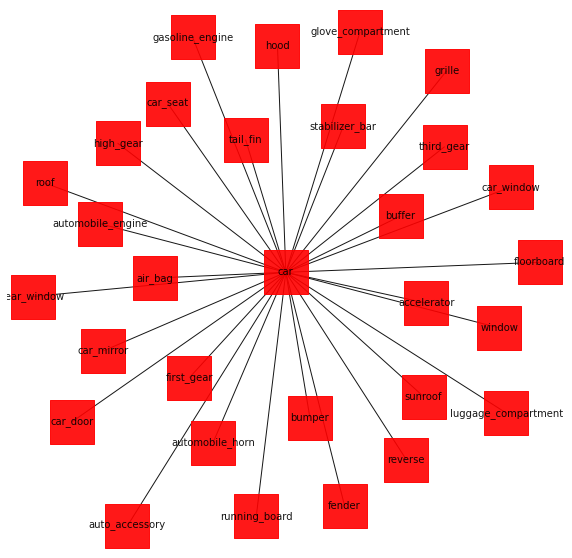

In [182]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')


Можно посчитать близость между синсетами (зависит от того, какой путь нужно пройти по этим связям от одного объекта до другого и есть ли он вообще)

In [183]:
car = wn.synsets('car')[0]
bike = wn.synsets('bike')[0]

In [184]:
bike.path_similarity(car)

0.3333333333333333

Есть и другие метрики:

In [185]:
wn.lch_similarity(bike, car)

2.538973871058276

In [186]:
wn.wup_similarity(bike, car)

0.9166666666666666

Датасеты для обучения и оценки WSD моделей обычно используют смыслы из WordNet. Например, http://lcl.uniroma1.it/wsdeval/ Там очень много данных, поэтому я взял небольшой кусок

In [187]:
corpus_wsd = []
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

Корпус состоит из предложений, где у каждого слова три поля - значение, лемма и само слово. Значение пустое, когда слово однозначное, а у многозначных слов стоит тэг вида **'long%3:00:02::'** Это тэг wordnet'ного формата

In [188]:
corpus_wsd[0]

[['', 'how', 'How'],
 ['long%3:00:02::', 'long', 'long'],
 ['', 'have', 'has'],
 ['', 'it', 'it'],
 ['be%2:42:03::', 'be', 'been'],
 ['', 'since', 'since'],
 ['', 'you', 'you'],
 ['review%2:31:00::', 'review', 'reviewed'],
 ['', 'the', 'the'],
 ['objective%1:09:00::', 'objective', 'objectives'],
 ['', 'of', 'of'],
 ['', 'you', 'your'],
 ['benefit%1:21:00::', 'benefit', 'benefit'],
 ['', 'and', 'and'],
 ['service%1:04:07::', 'service', 'service'],
 ['program%1:09:01::', 'program', 'program'],
 ['', '?', '?']]

Вот так можно достать соответствующий этому тэгу синсет:

In [189]:
wn.lemma_from_key('review%2:31:00::').synset()

Synset('review.v.01')

In [190]:
wn.lemma_from_key('review%2:31:00::').synset().definition()

'look at again; examine again'